# Interpolation using PyKrige

This week we are going to interpolate our soil geochemistry dataset using `pykrige`. So to do that we first need to install it with `pip`

In [ ]:
! pip install pykrige

This week we are using a lot of the code from last weeks Gaussian process. Mostly we are reusing the grid construction portion and plotting sections. So we will start with the same imports as last week

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from itertools import product
import contextily as ctx

%matplotlib inline

Then let's read in the data with `geopandas`

In [2]:
data = gpd.read_file("geochemistry_subset.shp")
data.drop(
    index=[3, 16], inplace=True
)

And here is the code we used last week to build our grid from the bounds of our soil samples

In [3]:
x_values = np.linspace(min(data.geometry.x), max(data.geometry.x), num=50)
y_values = np.linspace(min(data.geometry.y), max(data.geometry.y), num=50)
xy = np.array(list(product(x_values, y_values)))
X0, X1 = xy[:, 0].reshape(50, 50), xy[:, 1].reshape(50, 50)

To use `pykrige` we just need to import `OrdinaryKriging`

In [4]:
from pykrige.ok import OrdinaryKriging

We feed in our x and y sample locations, the element concentration (`qvalue`), and pick a `variogram_model`, here I chose `'spherical'` because it fits the data better than other models. I also enable `verbose=True` to see what it's doing, and then `enable_plotting=True` to see what the variogram model looks like

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 349.99
Full Sill: 350.0
Range: 100000
Nugget: 0.01 



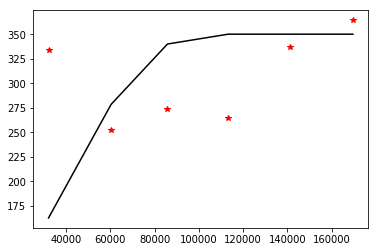

Calculating statistics on variogram model fit...


In [5]:
OK = OrdinaryKriging(
    data.geometry.x,
    data.geometry.y,
    data.qvalue,
    variogram_model="spherical",
    variogram_parameters= {'sill': 350, 'range': 100000, 'nugget': 0.01},
    verbose=True,
    enable_plotting=True,
)

Now that we have a variogram model we are set to make interpolation predictions on the grid. To do that we use `OK.execute` with `grid` and `x_values` and `y_values`

In [6]:
predictions, variance = OK.execute("grid", x_values, y_values)

Executing Ordinary Kriging...



Use our contextily helper function for plotting on a map

In [7]:
# this cell creates a function that grabs the stamen terrain tiles
def add_basemap(
    ax, zoom, url="http://tile.stamen.com/terrain/tileZ/tileX/tileY.png"
):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(
        xmin, ymin, xmax, ymax, zoom=zoom, url=url
    )
    ax.imshow(basemap, extent=extent, interpolation="bilinear")
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

And then we plot it up on top of the map with the sample locations to see how our model stacked up

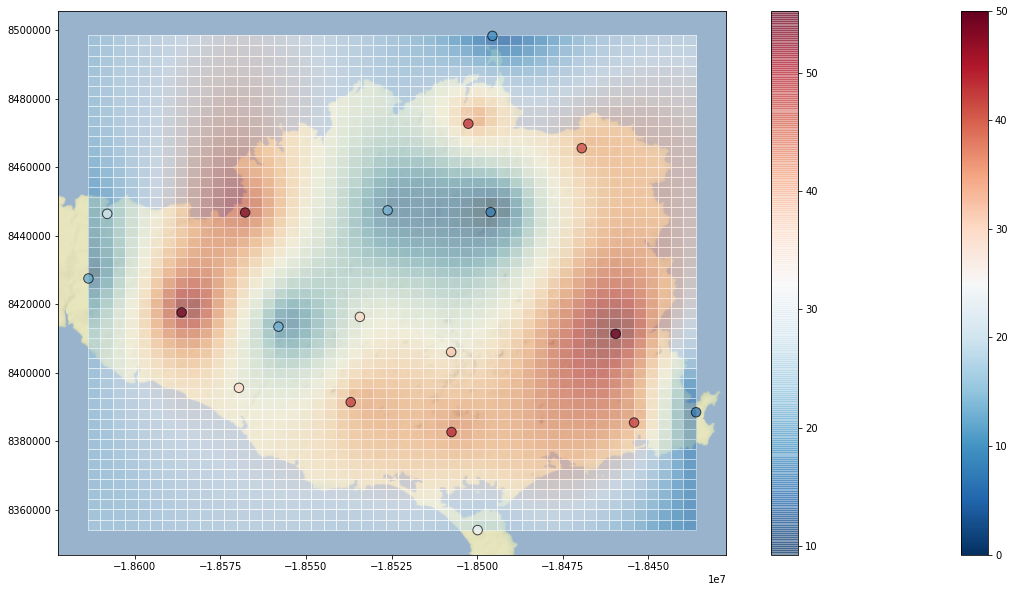

In [8]:
ax = data.plot(
    column="qvalue",
    vmin=0,
    vmax=50,
    figsize=(20, 10),
    legend=True,
    cmap="RdBu_r",
    alpha=0.7,
    edgecolor="k",
    markersize=90,
    zorder=2,
)
add_basemap(ax, zoom=9)  # add our basemap to the plot
im = ax.pcolormesh(
    X0,
    X1,
    predictions.T,
    cmap="RdBu_r",
    alpha=0.5,
    zorder=1,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
)
plt.colorbar(im, ax=ax)

And just like last week we can also plot up the error. In this case its the squared standard deviation. 

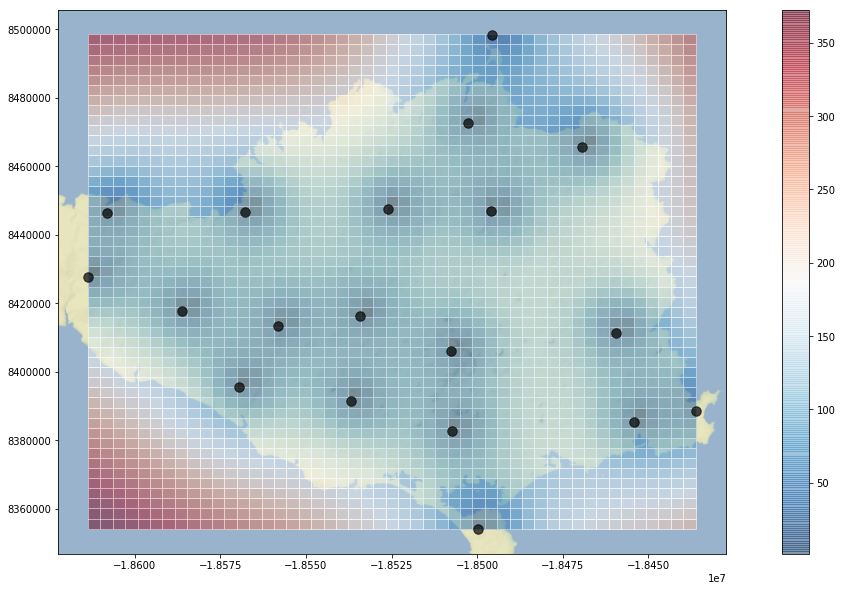

In [9]:
ax = data.plot(
    figsize=(20, 10),
    legend=True,
    color="black",
    alpha=0.7,
    markersize=90,
    zorder=2,
)
add_basemap(ax, zoom=9)  # add our basemap to the plot
im = ax.pcolormesh(
    X0,
    X1,
    variance.T,
    cmap="RdBu_r",
    alpha=0.5,
    zorder=1,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
)
plt.colorbar(im, ax=ax)

This notebook is licensed as CC-BY, use and share to your hearts content.